# Yield Playground
This notebook is meant to be a playground to try out different yield models and fit them by eye to the measured dataset.

The code is basically taken from R68_MCMC_MPI.py

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from tqdm.notebook import tqdm
from matplotlib.pyplot import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [3]:
import numpy as np
import pandas as pd
from constants import *

import R68_load as r68
import R68_spec_tools as spec
#Import likelihood functions
from likelihoods import *
import R68_efficiencies as eff

In [4]:
#Construct a dictionary to store all the MCMC fit parameters and results
        ########################## Data Settings ##########################
mcmc_data={'g4_load_frac':1.0,
          'cap_load_frac':1.0,
          'cap_sim_file':'/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl',
          'cap_rcapture':0.161,
           ########################## Spectrum Settings ##########################
          'Emax': 2000, #2000, #[eVee]
          'Ebins': np.linspace(0,2000,201), #np.linspace(0,2000,201),
           'Efit_min':50, #[eVee]
           'Efit_max':1750, #[eVee]
           'spectrum_units':'reco-rate', #One of {'counts', 'reco-rate'}
           ########################## Yield Model Settings ##########################
           #'Ymodel':'Lind',
           #'labels': [r'k', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((0.05,0.3),(0,30),(0.1,10),(0.1,10)),
           #'Ymodel':'Chav',
           #'labels': [r'k', r'$a^{-1}$', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((0.05,0.3),(0,2e3),(0,30),(0.1,10),(0.1,10)),
           #'Ymodel':'Sor',
           #'labels': [r'k', r'q', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((0.05,0.3),(0,3e-2),(0,30),(0.1,10),(0.1,10)),
           #'Ymodel':'AC',
           #'labels': [r'k', r'$\xi$', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((0.05,0.3),(0,2e3),(0,30),(0.1,10),(0.1,10)),
           #'Ymodel':'pchip',
           #'labels': [r'k', 'Er0', 'Er1', 'Er2', 'f1', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((0.05,0.3),(0,1e-3),(0,1e-3),(0,1e-3),(0,1),(0,10),(0.1,10),(0.1,10)),
           #'Ymodel':'Shexp',
           #'labels': [r'k', 'Yshelf', 'Ec', 'dE', 'alpha', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((0.05,0.3),(0,0.3),(0,1e3),(0,1e3),(0,100),(0,30),(0.1,10),(0.1,10)),
           #'Ymodel':'Pol3',
           #'labels': [r'p0', r'p1', r'p2', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$'],
           #'theta_bounds': ((-0.5,0.5),(-5e-4,5e-4),(-5e-7,5e-7),(0,30),(0.1,10),(0.1,10)),
           ########################## Likelihood Settings ##########################
           'likelihood':'SNorm', #One of {'Pois', 'Norm', 'SNorm'} Only SNorm accepts sigmas, others assume Pois stats
           ########################## Uncertainty Settings ##########################
           'doDetRes': True, #Include detector resolution effects
           'fpeak':0.753, #0.753 -- 1.0
           'doEffsyst':False, #Include systematics from cut efficiencies
           'doBurstLeaksyst':False, #Include burst cut leakage systematic
          }

In [5]:
Emax=mcmc_data['Emax']
Ebins=mcmc_data['Ebins']
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2

#Set fit range
E_lim_min=mcmc_data['Efit_min'] #eVee
E_lim_max=mcmc_data['Efit_max'] #eVee
spec_bounds=(np.digitize(E_lim_min,Ebins)-1,np.digitize(E_lim_max,Ebins)-1)
mcmc_data['spec_bounds']=spec_bounds

#Measured spectra background subtraction
meas=r68.load_measured(verbose=True)
tlive_PuBe=meas['PuBe']['tlive']

#Note that N_meas may be either in counts or reconstructed rate, depending on mcmc_data['spectrum_units']
#uncertainty is (high,low)
N_meas,dN_meas=spec.doBkgSub(meas, Ebins, mcmc_data['Efit_min'], mcmc_data['Efit_max'],\
                             doEffsyst=mcmc_data['doEffsyst'], doBurstLeaksyst=mcmc_data['doBurstLeaksyst'],\
                             output=mcmc_data['spectrum_units'])

if mcmc_data['likelihood']=='SNorm':
    #Precalculate split normal likelihood params if we're going to need it
    SNpars=getSNparsArray(N_meas[slice(*spec_bounds)],dN_meas[0][slice(*spec_bounds)],dN_meas[1][slice(*spec_bounds)])
    SNpars=SNpars.T

#Load g4 Simulations
g4=r68.load_G4(load_frac=mcmc_data['g4_load_frac'])
cap=r68.load_simcap(file=mcmc_data['cap_sim_file'], rcapture=mcmc_data['cap_rcapture'], load_frac=mcmc_data['cap_load_frac'])

#Trim events that won't figure into the analysis range
#Trimmed sim data
Eee_er=np.sum(g4['ER']['E'],axis=1)
Evec_er_cut=(Eee_er>10) & (Eee_er<3e3)
Evec_er=g4['ER']['E'][Evec_er_cut]

Eee_nr=np.sum(g4['NR']['E'],axis=1)
Evec_nr_cut=(Eee_nr>10) & (Eee_nr<30e3)
Evec_nr=g4['NR']['E'][Evec_nr_cut]

#Calculate Simulated ER spectrum
#This is independent of other params, so we can do this once and reuse it
if mcmc_data['spectrum_units']=='counts':
    N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1,\
                                       doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                       doEffs=True)    
elif mcmc_data['spectrum_units']=='reco-rate':
    N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1,\
                                       doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                       doEffs=False)

Loading Measured Data...
PuBe events:  (476731,)
Bkg events:  (174636,)


../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg
../python/R68_spec_tools.py:69: RuntimeWarning: invalid value encountered in multiply
  doEffsyst*(dTE_Bkg/TE_Bkg)**2 )


Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.1  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
400000


In [406]:
#Import yield models
import R68_yield as Yield

#Initialize Yield model
Y=Yield.Yield('Lind',[0.1])

In [407]:
#Model parameters
# [{Yield params}, F_NR, G4 scale, capture sim scale]
theta=[*(Y.pars),0.1,1.0,5.0]
ERscale2=5

In [408]:
############
#Set some local variables
nYpar=Y.npars

Y.set_pars(theta[:nYpar])
F_NR=theta[nYpar]
scale_g4=theta[nYpar+1]
scale_ng=theta[nYpar+2]


#Calculate the (log)prior first since we may not need to calculate the likelihood
#lp=lp_flat(theta, theta_bounds)
#if not np.isfinite(lp):
#    return -np.inf

#Special check for pchip yield
#Will fail to solve if the parameters are not ordered.
#This effectively includes some parameter ordering in their priors
if not Y.solve():
    print('return -np.inf')


##########
#Build the spectra
if mcmc_data['spectrum_units']=='counts':
    #This includes detector resolution, triggering, and cut efficiency effects
    #Does NOT include livetime or write efficiency

    #NR
    N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1,\
                                     doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                     doEffs=True)
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1,\
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                               doEffs=True)


    #Adjust for livetime and write efficiency
    N_nr_this=N_nr*scale_g4/g4['NR']['tlive']*tlive_PuBe*eff.eff_write
    N_er_this=N_er*scale_g4/g4['ER']['tlive']*tlive_PuBe*eff.eff_write*ERscale2
    N_ng_this=N_ng*scale_ng/cap['tlive']*tlive_PuBe*eff.eff_write
    N_tot_this = N_nr_this + N_er_this + N_ng_this

elif mcmc_data['spectrum_units']=='reco-rate':
    #Don't apply any efficiency effects to simulated spectrum
    #NR
    N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1,\
                                     doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                     doEffs=False)
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1,\
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                               doEffs=False)
    #Calculate rate
    N_nr_this=N_nr*scale_g4/g4['NR']['tlive']
    N_er_this=N_er*scale_g4/g4['ER']['tlive']*ERscale2
    N_ng_this=N_ng*scale_ng/cap['tlive']
    N_tot_this = N_nr_this + N_er_this + N_ng_this

##########
#Calculate the log probability = log prior + log likelihood
ll=None

likelihood=mcmc_data['likelihood']
if likelihood=='Norm':
    ll = ll_norm(N_meas[slice(*spec_bounds)],N_tot_this[slice(*spec_bounds)])
elif likelihood=='Pois':
    ll = ll_pois(N_meas[slice(*spec_bounds)],N_tot_this[slice(*spec_bounds)])
elif likelihood=='SNorm':
    ll = ll_SNorm(N_tot_this[slice(*spec_bounds)],*SNpars)
else:
    print('Error: Bad likelihood')
    print('return None')

Log Likelihood: -3610.0


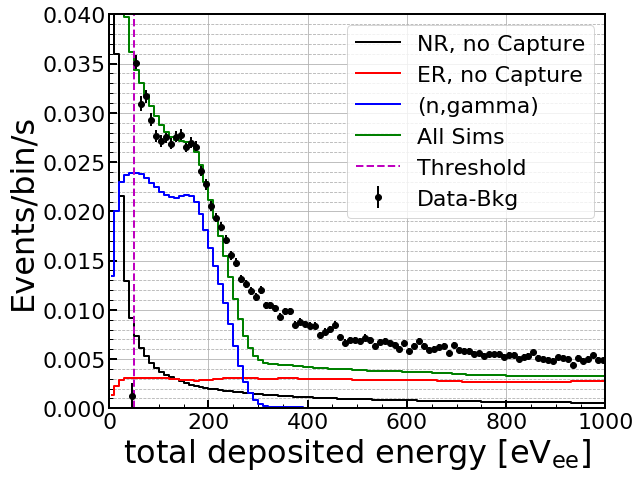

In [414]:
if mcmc_data['spectrum_units']=='counts':
    yrange=(0,3e3)
elif mcmc_data['spectrum_units']=='reco-rate':
    yrange=(0,4e-2)
#Make the plot
ax=spec.plotSpectra(E_bins=Ebins, N_nr=N_nr_this, N_er=N_er_this, N_ng=N_ng_this, N_tot=N_tot_this,
                    N_meas=N_meas, dN_meas=dN_meas,
                    xrange=(0,1e3), yrange=yrange, thresh=Ebins[np.digitize(mcmc_data['Efit_min'],Ebins)-1],
                    wResidual=False, yrange_res=(-100,100))

print(f'Log Likelihood: {ll:.1f}')

138.4/95 = 1.46
[5.11033706e-01 4.49399119e-03 1.90855616e-02 2.57141098e+02
 3.21038539e+04 3.38758111e+00]


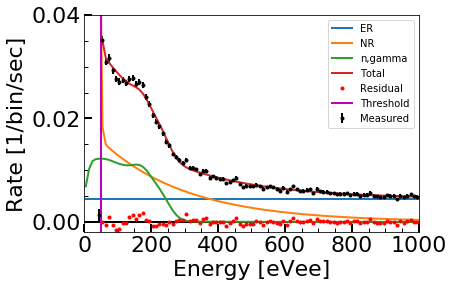

In [410]:
Ectr=(Ebins[:-1]+Ebins[1:])/2

#plot(Ectr,N_meas,'.k',label='Measured')
errorbar(Ectr,N_meas,dN_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

#plot(Ectr,N_ng_this)
#N_test=0.65*N_ng_this+4e-3+1.3e-2*np.exp(-Ectr/400)+2.8e-2*np.exp(-Ectr/20)
N_test=sig_tot(0.65,4e-3,1.3e-2,400,2.8e-2,20)

#plot(Ectr[cfit],N_test)
#plot(Ectr[cfit],N_meas[cfit]-N_test,'.r')

from scipy.optimize import minimize
#Crude models with flat ERs at f0, and 2-exp NRs
cfit=(N_meas>0) & (Ectr>50) & (Ectr<1e3)
def sig_tot(fng, f0, f1, tau1, f2, tau2):
    return fng*N_ng_this[cfit]+f0+f1*np.exp(-Ectr[cfit]/tau1)+f2*np.exp(-Ectr[cfit]/tau2)

fchisq = lambda theta: np.sum(((sig_tot(*theta)-N_meas[cfit])/np.mean(dN_meas,axis=0)[cfit])**2)

res=minimize(fchisq,x0=[0.65,4e-3,1.3e-2,400,2.8e-2,20])
print(f'{res.fun:.1f}/{np.sum(cfit):.0f} = {res.fun/np.sum(cfit):.2f}' )


plot(Ectr,res.x[1]*(Ectr>0),label='ER')
plot(Ectr,res.x[2]*np.exp(-Ectr/res.x[3])+res.x[4]*np.exp(-Ectr/res.x[5]),label='NR')
plot(Ectr,res.x[0]*N_ng_this,label='n,gamma')
plot(Ectr[cfit],sig_tot(*res.x),label='Total')
plot(Ectr[cfit],N_meas[cfit]-sig_tot(*res.x),'.r',label='Residual')

axvline(50,color='m',label='Threshold')
axhline(0,color='k',zorder=0)

xlabel('Energy [eVee]')
ylabel('Rate [1/bin/sec]')

ylim(-2e-3,0.04)
xlim(0,1e3)
legend()

print(res.x)

In [413]:
3/Y.calc(3)

44.59450288139694

In [387]:
#Okay, let's optimize a little more by looping over yield params

ks=np.linspace(0.05,0.2,10)
qs=np.linspace(0,1e-2,10)

xk,xq = np.meshgrid(ks,qs)

N_ngs=[]
popts=[]
chis=[]
for k,q in zip(tqdm(xk.flatten()),xq.flatten()):
    #Initialize Yield model
    #Y=Yield.Yield('Lind',[k])
    Y=Yield.Yield('Sor',[k,q])
    F_NR=0.1
    scale_ng=1
    
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1,\
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                               doEffs=False)

    #Calculate rate
    N_ng_this=N_ng*scale_ng/cap['tlive']
    #N_tot_this = N_nr_this + N_er_this + N_ng_this

    from scipy.optimize import minimize
    #Crude models with flat ERs at f0, and 2-exp NRs
    cfit=(N_meas>0) & (Ectr>50) & (Ectr<1e3)
    def sig_tot(fng, f0, f1, tau1, f2, tau2):
        return fng*N_ng_this[cfit]+f0+f1*np.exp(-Ectr[cfit]/tau1)+f2*np.exp(-Ectr[cfit]/tau2)

    fchisq = lambda theta: np.sum(((sig_tot(*theta)-N_meas[cfit])/np.mean(dN_meas,axis=0)[cfit])**2)

    res=minimize(fchisq,x0=[2.5,4e-3,1.3e-2,400,2.8e-2,20],bounds=[(0,5),(0,1),(0,1),(0,1e3),(0,1),(0,1e3)])
    
    N_ngs.append(N_ng_this)
    popts.append(res.x)
    chis.append(res.fun/np.sum(cfit))

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


1.743877989077389 15 [2.90753274e+00 4.22801623e-03 8.37487127e-03 3.84073276e+02
 1.43506038e-02 1.60303272e+02] 0.13333333333333336 0.0011111111111111111


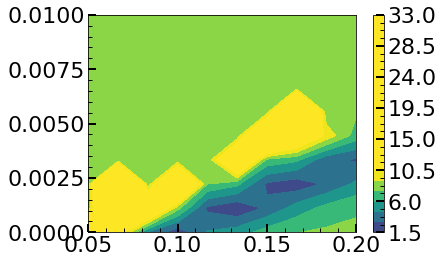

In [399]:
#plot(ks,chis,'-o')
#print(min(chis),np.argmin(chis),popts[np.argmin(chis)])

contourf(xk,xq,np.reshape(chis,xk.shape),levels=25,vmin=0,vmax=10)
colorbar()
print(min(chis),np.argmin(chis),popts[np.argmin(chis)],xk.flatten()[np.argmin(chis)],xq.flatten()[np.argmin(chis)])

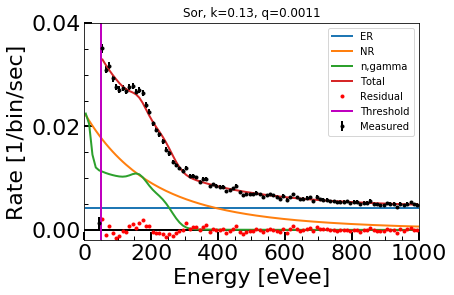

In [403]:
i=np.argmin(chis)
popt=popts[i]

errorbar(Ectr,N_meas,dN_meas, ecolor='k', marker='.',color='k', linestyle='none',label='Measured')

plot(Ectr,popt[1]*(Ectr>0),label='ER')
plot(Ectr,popt[2]*np.exp(-Ectr/popt[3])+popt[4]*np.exp(-Ectr/popt[5]),label='NR')

plot(Ectr,popt[0]*N_ngs[i],label='n,gamma')

total=popt[0]*N_ngs[i]+popt[1]*(Ectr>0)+popt[2]*np.exp(-Ectr/popt[3])+popt[4]*np.exp(-Ectr/popt[5])
plot(Ectr[cfit],total[cfit],label='Total')

plot(Ectr[cfit],N_meas[cfit]-total[cfit],'.r',label='Residual')

axvline(50,color='m',label='Threshold')
axhline(0,color='k',zorder=0)

xlabel('Energy [eVee]')
ylabel('Rate [1/bin/sec]')

#title(f'Lind, k={ks[i]:.2f}')
title(f'Sor, k={xk.flatten()[np.argmin(chis)]:.2f}, q={xq.flatten()[np.argmin(chis)]:.2g}')

ylim(-2e-3,0.04)
xlim(0,1e3)
legend()